### jupyter notebook dfr the exploratory data analysis of the onet data enriched with historical data from Osborne & Frey

author: Jan Jörg
date: 14.03.2024

In [793]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import json
import plotly.graph_objects as go
from itertools import chain
from db import get_database
from sklearn.metrics import * 
from sklearn.utils import resample
from matplotlib import rcParams
import statsmodels.api as sm
import pylab as py
import matplotlib.colors as mcolors

In [794]:
dbname = get_database()
df_col = dbname["fo_with_id"]
education = dbname["education"]
job_zone = dbname["job_zone"]
abilities = dbname["abilities"]
skills = dbname["skills"]

education =  pd.DataFrame(list(education.find()))
job_zone = pd.DataFrame(list(job_zone.find()))
df = pd.DataFrame(list(df_col.find()))
abilities = pd.DataFrame(list(abilities.find()))
skills = pd.DataFrame(list(skills.find())) 

print(df.shape[0])
df.head(2)

326


,_id,job_zone,education,isco08,Name_de,Berufshauptgruppe,s10,s1,s4,s11,...,a36,a39,a41,a43,a44,a28,a40,a49,fo_probability,fo_computerisation
0,663e2380db2fdc9e602a95bc,4,9,2612,Richter,2,78,81,72,78,...,0,28,16,0,31,22,6,0,0.400,na
1,663e2380db2fdc9e602a9516,2,2,2120,"Mathematiker, Aktuare und Statistiker",2,81,81,50,63,...,0,78,0,0,91,13,13,0,0.035,na


In [795]:
# drop columns
skills = skills.drop(columns=["_id", "id", "description"])
abilities = abilities.drop(columns=["_id", "id", "description"])

In [796]:
# rename columns
skills = skills.rename(columns={"name": "skill"})
abilities = abilities.rename(columns={"name": "ability"})

In [798]:
# Add a letter in front of 'id' column
skills['skill_id'] = 's' + skills['skill_id'].astype(str)
abilities['ability_id'] = 'a' + abilities['ability_id'].astype(str)

In [799]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 95 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _id                 326 non-null    object 
 1   job_zone            326 non-null    int64  
 2   education           326 non-null    int64  
 3   isco08              326 non-null    object 
 4   Name_de             326 non-null    object 
 5   Berufshauptgruppe   326 non-null    object 
 6   s10                 326 non-null    int64  
 7   s1                  326 non-null    int64  
 8   s4                  326 non-null    int64  
 9   s11                 326 non-null    int64  
 10  s22                 326 non-null    int64  
 11  s6                  326 non-null    int64  
 12  s19                 326 non-null    int64  
 13  s18                 326 non-null    int64  
 14  s3                  326 non-null    int64  
 15  s15                 326 non-null    int64  
 16  s2      

In [800]:
df.describe().round(2)

,job_zone,education,s10,s1,s4,s11,s22,s6,s19,s18,...,a34,a36,a39,a41,a43,a44,a28,a40,a49,fo_probability
count,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,...,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00
mean,2.16,3.45,55.10,59.41,53.38,51.83,20.06,57.65,40.32,47.26,...,28.46,12.57,37.80,37.63,4.37,38.75,42.07,22.42,21.06,0.43
std,1.23,2.22,12.04,13.76,11.83,15.55,20.17,10.59,14.14,13.23,...,21.27,14.09,13.51,22.35,7.22,15.27,15.88,11.27,18.59,0.39
min,1.00,1.00,28.00,25.00,25.00,19.00,0.00,22.00,3.00,19.00,...,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00
25%,1.00,2.00,47.00,50.00,44.00,44.00,3.00,50.00,28.00,35.00,...,3.00,0.00,25.00,19.00,0.00,25.00,28.00,13.00,0.00,0.03
50%,2.00,3.00,53.00,56.00,50.00,50.00,16.00,53.00,41.00,47.00,...,28.00,8.00,38.00,41.00,0.00,36.50,47.00,25.00,19.00,0.36
75%,3.00,3.00,66.00,72.00,63.00,66.00,31.00,69.00,53.00,53.00,...,47.00,25.00,47.00,53.00,6.00,50.00,53.00,28.00,35.00,0.84
max,5.00,12.00,81.00,94.00,81.00,94.00,81.00,78.00,75.00,78.00,...,72.00,66.00,78.00,91.00,50.00,91.00,81.00,53.00,97.00,0.99


In [802]:
df["education"] = df["education"].astype(int)
df["job_zone"] = df["job_zone"].astype(int)
df["fo_probability"] = df["fo_probability"].astype(float)
df["fo_computerisation"] =  pd.to_numeric(df["fo_computerisation"], errors='coerce').fillna(0).astype(int)  # this will convert na to 0, which is wrong. the issue is solved later on

In [803]:
#Get Number per class 
freq = df['fo_computerisation'].value_counts()
print(freq)

fo_computerisation
0    314
1     12
Name: count, dtype: int64


In [804]:
# Create a new column 'switch' based on 'df_probability'
df['fo_computerisation'] = df['fo_probability'].apply(lambda x: 1 if x >= 0.5 else 0)

In [805]:
#Get Number per class 
freq = df['fo_computerisation'].value_counts()
print(freq)

fo_computerisation
0    178
1    148
Name: count, dtype: int64


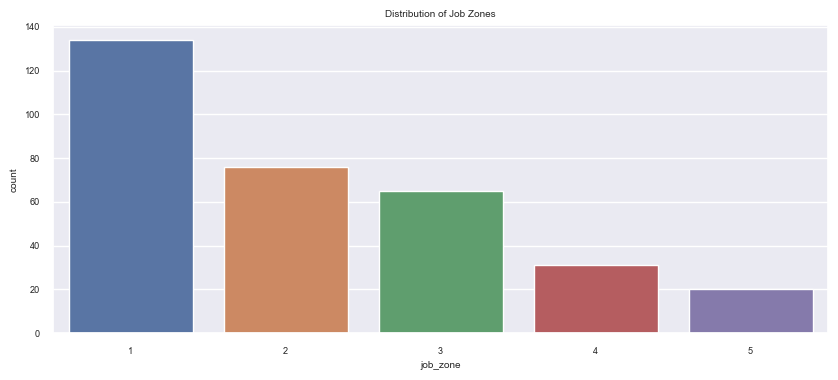

Zone 1:  These occupations usually require a high school diploma.
Zone 2:  Most of these occupations require a four-year bachelor's degree, but some do not.
Zone 3:  Most occupations in this zone require training in vocational schools, related on-the-job experience, or an associate's degree.
Zone 4:  Most of these occupations require graduate school. For example, they may require a master's degree, and some require a Ph.D., M.D., or J.D. (law degree).
Zone 5:  Some of these occupations may require a high school diploma or GED certificate.


In [806]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='job_zone', order = df['job_zone'].value_counts().index)
plt.title('Distribution of Job Zones')
plt.show()

for i, row in job_zone.iterrows():
    print(f"Zone {row['job_zone_id']}:  {row['education']}")

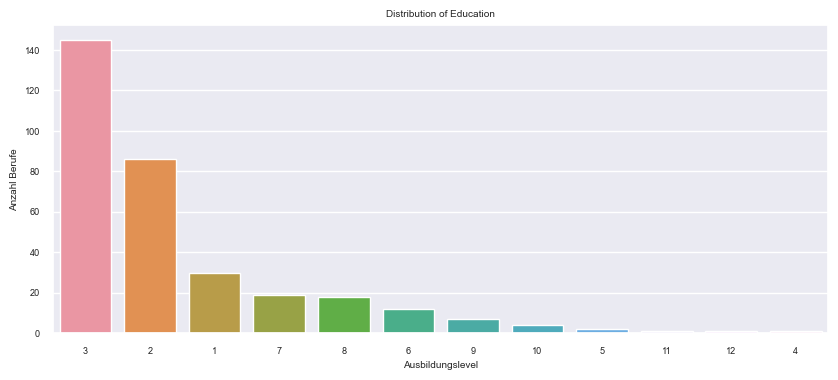

1:  Less than high school diploma
2:  Bachelor's degree
3:  High school diploma or equivalent
4:  Post-baccalaureate certificate
5:  Professional degree
6:  Associate's degree
7:  Master's degree
8:  Post-secondary certificate
9:  Doctoral degree
10:  Some college, no degree
11:  Post-doctoral training
12:  Post-master's certificate


In [807]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='education', order = df['education'].value_counts().index)
plt.title('Distribution of Education')
plt.ylabel('Anzahl Berufe')
plt.xlabel('Ausbildungslevel')
plt.show()

for i, row in education.iterrows():
    print(f"{row['education_id']}:  {row['name']}")

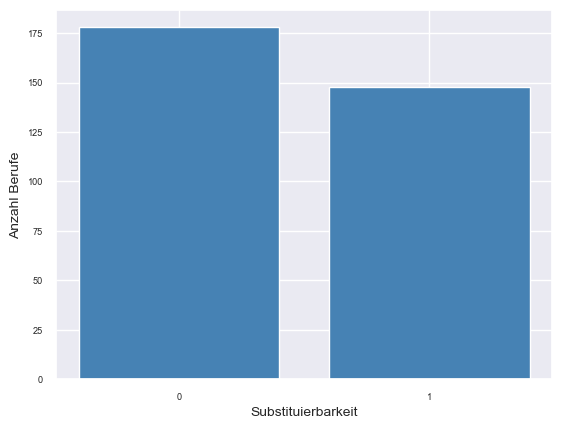

In [808]:
# Get number per class
freq = df['fo_computerisation'].value_counts()

# Create a bar chart
plt.bar(freq.index, freq.values, color="#4682B4")
# plt.title('Substituierbarkeit nach Osborne & Frey (2013)')
plt.ylabel('Anzahl Berufe', fontsize = 10)
plt.xticks(freq.index)
plt.xlabel('Substituierbarkeit', fontsize = 10)
plt.show()

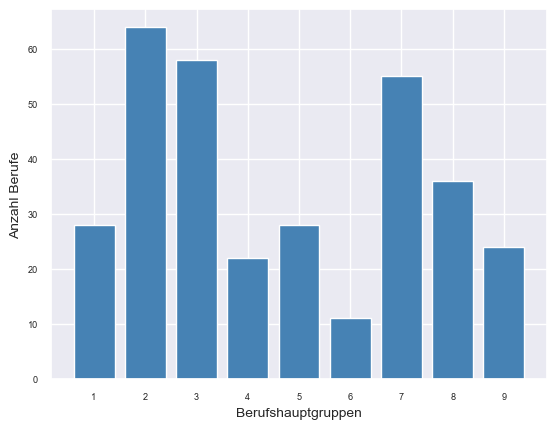

In [809]:
# Get number per class and sort by index
freq = df['Berufshauptgruppe'].value_counts().sort_index()

# Create a bar chart
plt.bar(range(len(freq)), freq.values, color="#4682B4")

# Set title, x-label, y-label, and x-ticks
plt.ylabel('Anzahl Berufe', fontsize = 10)
plt.xlabel('Berufshauptgruppen', fontsize = 10)
plt.xticks(range(len(freq)), freq.index)

# Show the figure
plt.show()

In [810]:
# Select only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Calculate correlation
corr = df_numeric.corr()

# Display the correlation matrix
corr

,job_zone,education,s10,s1,s4,s11,s22,s6,s19,s18,...,a36,a39,a41,a43,a44,a28,a40,a49,fo_probability,fo_computerisation
job_zone,1.000000,0.297627,0.259513,0.223061,0.296155,0.276394,0.226624,0.110795,0.216405,0.228428,...,-0.191834,0.097596,-0.171394,-0.069764,0.114283,-0.196151,-0.149754,-0.189056,-0.268019,-0.210436
education,0.297627,1.000000,0.174923,0.251970,0.171839,0.248213,0.309339,0.101448,0.154218,0.200084,...,-0.087480,0.052526,0.015746,-0.126388,0.045703,0.060815,-0.006842,-0.034631,-0.249932,-0.258939
s10,0.259513,0.174923,1.000000,0.770029,0.672323,0.764724,0.466438,0.759453,0.833295,0.487882,...,-0.264212,0.584499,-0.434502,-0.327394,0.625416,-0.465285,-0.335222,-0.356195,-0.615497,-0.566945
s1,0.223061,0.251970,0.770029,1.000000,0.655073,0.907829,0.486760,0.609810,0.732116,0.528739,...,-0.444883,0.544949,-0.561891,-0.471957,0.606383,-0.515339,-0.406269,-0.540124,-0.512661,-0.497289
s4,0.296155,0.171839,0.672323,0.655073,1.000000,0.673929,0.161483,0.586650,0.557283,0.785329,...,-0.395636,0.319915,-0.582951,-0.341665,0.322103,-0.557855,-0.476520,-0.470523,-0.540139,-0.508542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a28,-0.196151,0.060815,-0.465285,-0.515339,-0.557855,-0.537627,-0.005614,-0.288573,-0.386805,-0.446954,...,0.473488,-0.291044,0.850447,0.345633,-0.330256,1.000000,0.679940,0.678023,0.320121,0.329517
a40,-0.149754,-0.006842,-0.335222,-0.406269,-0.476520,-0.435714,-0.036301,-0.124780,-0.304406,-0.421662,...,0.497506,-0.162833,0.731116,0.401442,-0.215743,0.679940,1.000000,0.715187,0.302664,0.321625
a49,-0.189056,-0.034631,-0.356195,-0.540124,-0.470523,-0.549215,-0.018745,-0.179336,-0.348350,-0.457889,...,0.822362,-0.335856,0.872340,0.513452,-0.375562,0.678023,0.715187,1.000000,0.204038,0.239207
fo_probability,-0.268019,-0.249932,-0.615497,-0.512661,-0.540139,-0.515446,-0.344085,-0.534419,-0.551404,-0.431580,...,0.083767,-0.274323,0.285736,0.181165,-0.298342,0.320121,0.302664,0.204038,1.000000,0.950052


In [811]:
cov = df_numeric.cov()
cov

,job_zone,education,s10,s1,s4,s11,s22,s6,s19,s18,...,a36,a39,a41,a43,a44,a28,a40,a49,fo_probability,fo_computerisation
job_zone,1.521180,0.815196,3.854762,3.785276,4.322586,5.301359,5.636649,1.447796,3.775168,3.726210,...,-3.333044,1.625861,-4.725087,-0.621029,2.152289,-3.841774,-2.081340,-4.333582,-0.129121,-0.129420
education,0.815196,4.931723,4.678377,7.698971,4.516017,8.572213,13.853459,2.386937,4.844096,5.876791,...,-2.736744,1.575555,0.781614,-2.025805,1.549788,2.144653,-0.171232,-1.429335,-0.216802,-0.286739
s10,3.854762,4.678377,145.042643,127.596451,95.821010,143.225842,113.283492,96.905201,141.946748,77.712487,...,-44.825408,95.080868,-116.967135,-28.458386,115.012761,-88.985106,-45.493988,-79.726343,-2.895440,-3.404700
s1,3.785276,7.698971,127.596451,189.307447,106.661633,194.248023,135.059047,88.894950,142.476432,96.217386,...,-86.229089,101.274790,-172.806418,-46.868145,127.397282,-112.597055,-62.989920,-138.115790,-2.755210,-3.411798
s4,4.322586,4.516017,95.821010,106.661633,140.045644,124.027447,38.537763,73.554960,93.280189,122.917810,...,-65.956149,51.136442,-154.202265,-29.182784,58.204832,-104.834979,-63.546126,-103.486116,-2.496783,-3.000906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a28,-3.841774,2.144653,-88.985106,-112.597055,-104.834979,-132.770118,-1.797791,-48.551713,-86.880264,-93.873242,...,105.921378,-62.426711,301.870864,39.614667,-80.081227,252.173893,121.672883,200.106409,1.985659,2.609269
a40,-2.081340,-0.171232,-45.493988,-62.989920,-63.546126,-76.356055,-8.249363,-14.897669,-48.518301,-62.844323,...,78.976196,-24.784332,184.154998,32.650326,-37.122662,121.672883,126.983332,149.781878,1.332217,1.807230
a49,-4.333582,-1.429335,-79.726343,-138.115790,-103.486116,-158.736791,-7.025304,-35.312789,-91.571581,-112.552430,...,215.304672,-84.310392,362.389740,68.874280,-106.580472,200.106409,149.781878,345.408145,1.481217,2.216819
fo_probability,-0.129121,-0.216802,-2.895440,-2.755210,-2.496783,-3.131071,-2.710386,-2.211673,-3.046420,-2.229617,...,0.460932,-1.447322,2.494765,0.510747,-1.779443,1.985659,1.332217,1.481217,0.152574,0.185046


<Axes: xlabel='fo_probability'>

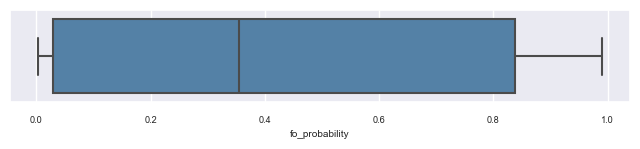

In [812]:
# boxplot of probabilities of computerisation
plt.figure(figsize=(8,1.2))
sns.boxplot(x=df['fo_probability'], color="#4682B4")

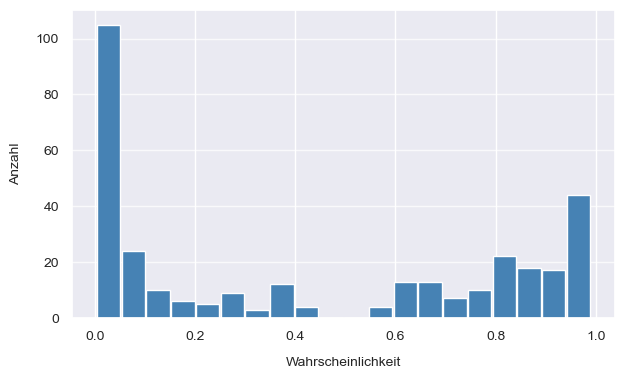

In [813]:
# Plot Histogram
fig = plt.figure( figsize=(7,4))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
n, bins, patches = plt.hist(x=df['fo_probability'], 
                            bins=20, 
                            color="#4682B4",
                            rwidth=0.95
                   )
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.grid(axis='y', alpha=0.75)

# Set labels
plt.xlabel('Wahrscheinlichkeit', fontsize=10, labelpad=10)
plt.ylabel('Anzahl', fontsize=10, labelpad=10)
# plt.title('Histogram of probability of computerisation', fontsize=12, pad=10)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

/opt/anaconda3/envs/bachelorarbeit/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(2.619444444444442, 0.5, 'Density')

<Figure size 700x400 with 0 Axes>

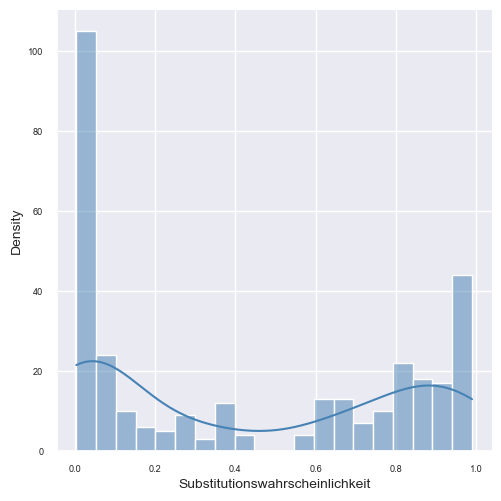

In [814]:
fig = plt.figure(figsize=(7,4))
sns.displot(df['fo_probability'], bins=20, color="#4682B4", kde=True)
# plt.title('Density plot computerisation probability', fontsize=12)
plt.xlabel('Substitutionswahrscheinlichkeit', fontsize=10)
plt.ylabel('Density', fontsize=10)

<Axes: >

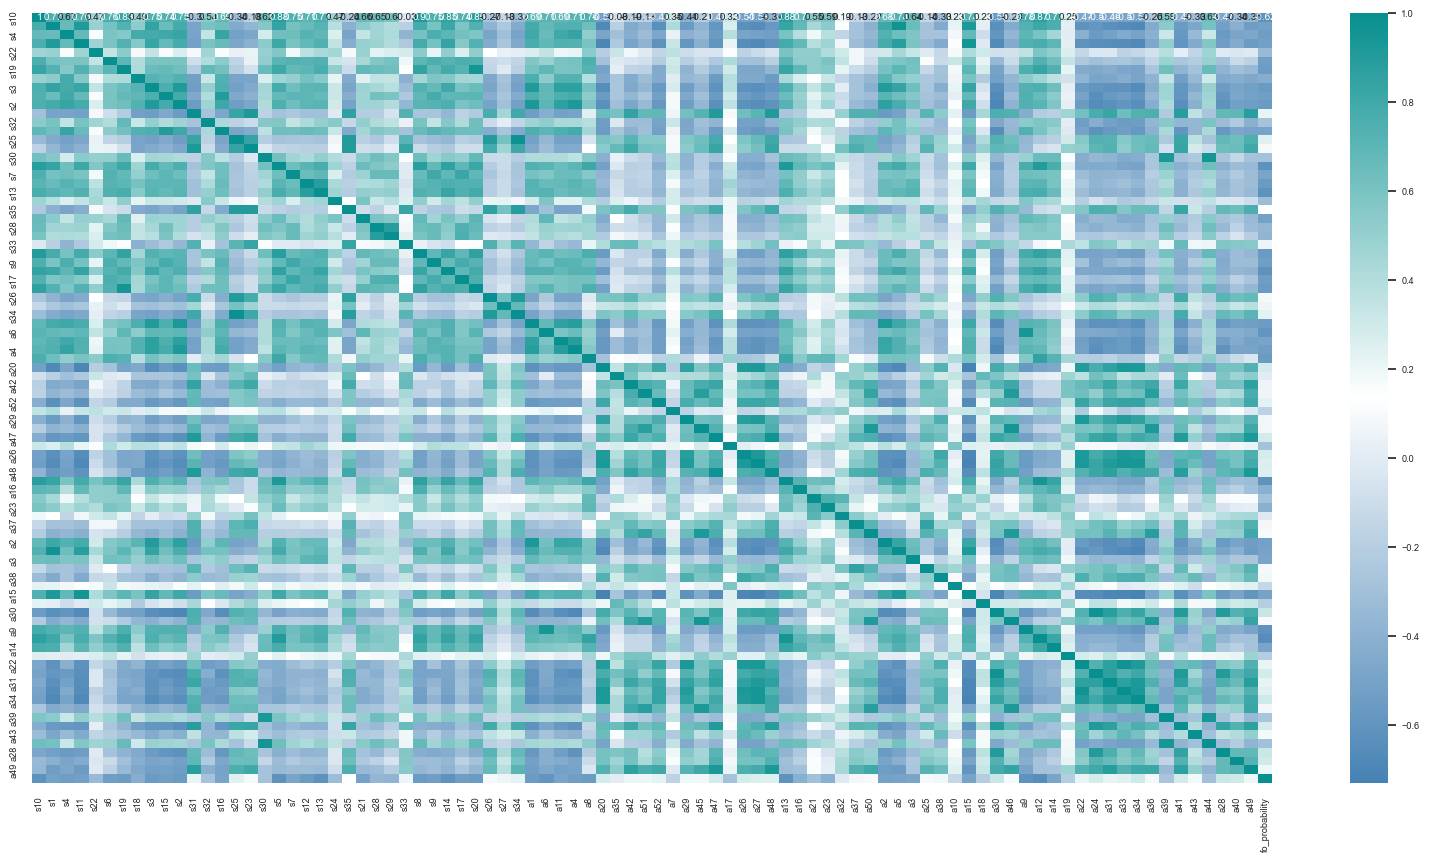

In [815]:
# correlation heatmap

# Set font size for plot
sns.set_theme(font_scale=0.6)

# Select columns that start with 's' or 'a' and the 'fo_probability' column
df_selected = df.filter(regex='^(s|a|fo_probability)')

# Create correlation matrix as the basis for the heatmap
plt.figure(figsize=(20,10))
corr = df_selected.select_dtypes(include=[np.number]).corr().round(2)

colors = ["#4682B4", "white", "#088F8F"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Plot heatmap
sns.heatmap(corr, 
            cmap=cmap, 
            annot=True)

Optimization terminated successfully.
         Current function value: 0.314385
         Iterations 7


/var/folders/ms/0wqr6tr506lfp142wmz0qph40000gn/T/ipykernel_1980/3659572217.py:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axhspan(-0.01, 0.01, color='#ff0000', alpha=0.3, edgecolor='none')
/var/folders/ms/0wqr6tr506lfp142wmz0qph40000gn/T/ipykernel_1980/3659572217.py:38: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axhspan(0.011, 0.05, color='#00FF00', alpha=0.1, edgecolor='none')
/var/folders/ms/0wqr6tr506lfp142wmz0qph40000gn/T/ipykernel_1980/3659572217.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axhspan(-0.05, -0.011, color='#00FF00', alpha=0.1, edgecolor='none')


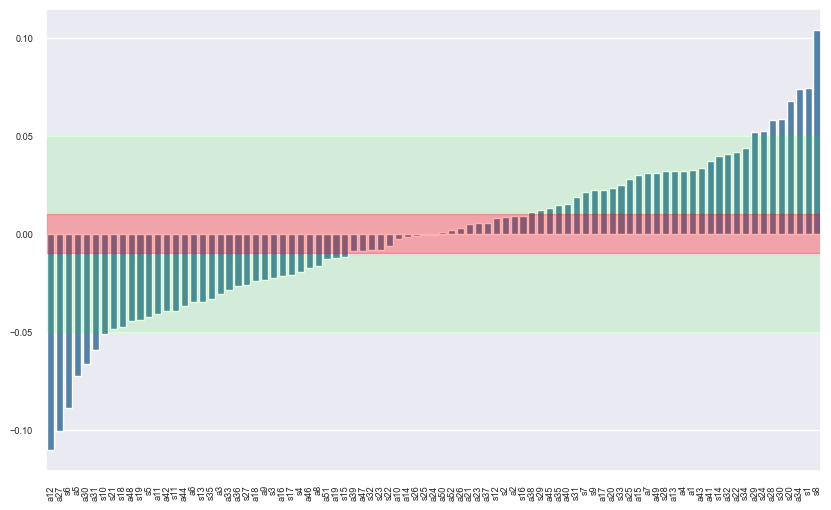

In [816]:

# Select columns that start with 's' or 'a' and the 'fo_probability' column
df_selected = df.filter(regex='^(s|a|fo_probability)')

# Define the dependent variable
y = df_selected['fo_probability']

# Define the independent variables
X = df_selected.drop('fo_probability', axis=1)

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Fit the model
model = sm.Logit(y, X)
results = model.fit()

# Get the regression coefficients
coefficients = results.params

# Drop the constant
coefficients = coefficients.drop('const')

# Sort the coefficients
coefficients = coefficients.sort_values()

# Create a bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=coefficients.index, y=coefficients.values, color="#4682B4")
# plt.title('Regression coefficients of fo_probability with other inputs', fontsize=12)
# plt.xlabel('Inputs', fontsize=10)
# plt.ylabel('Coefficient', fontsize=10)
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Konfidenzintervall 99%
plt.axhspan(-0.01, 0.01, color='#ff0000', alpha=0.3, edgecolor='none')

# Konfidenzintervall 95%
plt.axhspan(0.011, 0.05, color='#00FF00', alpha=0.1, edgecolor='none')
plt.axhspan(-0.05, -0.011, color='#00FF00', alpha=0.1, edgecolor='none')

plt.show()

In [817]:
# Extract coefficients outside the 95% confidence interval
coefficients_outside_95 = coefficients[(coefficients < -0.05) | (coefficients > 0.05)].round(4)

# Extract coefficients outside the 99% confidence interval
coefficients_outside_99 = coefficients[(coefficients < -0.01) | (coefficients > 0.01)].round(4)

In [818]:
coefficients_outside_99.head(5)

a12   -0.1104
a27   -0.1004
s6    -0.0886
a5    -0.0722
a30   -0.0661
dtype: float64

In [819]:
# Create a dataframe from the coefficients outside the 95% and 99% confidence intervals with headers
coefficients_outside_95 = pd.DataFrame(list(coefficients_outside_95.items()), columns=['id', 'coefficient'])
coefficients_outside_99 = pd.DataFrame(list(coefficients_outside_99.items()), columns=['id', 'coefficient'])

# Merge skills dataframe with coefficients
coefficients_outside_95 = coefficients_outside_95.merge(skills, left_on='id', right_on='skill_id', how='left')
coefficients_outside_99 = coefficients_outside_99.merge(skills, left_on='id', right_on='skill_id', how='left')

# Merge abilities dataframe with coefficients
coefficients_outside_95 = coefficients_outside_95.merge(abilities, left_on='id', right_on='ability_id', how='left')
coefficients_outside_99 = coefficients_outside_99.merge(abilities, left_on='id', right_on='ability_id', how='left')

# remove unnecessary columns
coefficients_outside_95 = coefficients_outside_95.drop(columns=['skill_id', 'ability_id'])
coefficients_outside_99 = coefficients_outside_99.drop(columns=['skill_id', 'ability_id'])

In [820]:
# Save the dataframes to csv files
coefficients_outside_95.reset_index().rename(columns={'index': 'Variable', 0: 'Coefficient'}).to_csv('files/coefficients_outside_95.csv', index=False)
coefficients_outside_99.reset_index().rename(columns={'index': 'Variable', 0: 'Coefficient'}).to_csv('files/coefficients_outside_99.csv', index=False)

In [821]:
df_majority = df[df.fo_computerisation==1]
df_minority = df[df.fo_computerisation==0]

In [822]:
# Upsample minority class 
df_minority_upsampled = resample(df_minority, replace=True, # sample with replacement 
                                 n_samples=177, # to match majority class 
                                 random_state=None) # reproducible results

In [823]:
# Combine majority class with upsampled minority class 
df_upsampled = pd.concat([df_majority, df_minority_upsampled])